# Word2Vec

The point of this lesson is to introduce how to represent categorical variables.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE

import zipfile
import collections

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data('text8.zip')
print('Data size %d' % len(words))
print(words[:10])

Data size 17005207
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [3]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5241, 3083, 12, 6, 195, 2, 3137, 46, 59, 156]


In [4]:
%%time
skip_window = 1
instances = len(data) - 2*skip_window
context = np.zeros((instances,skip_window*2+1),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)

k = 0
for i in range(skip_window, len(data)-skip_window):
    context[k] = data[i-skip_window:i+skip_window+1] # Get surrounding words
    labels[k] = data[i] # Get target variable
    k += 1
    
context = np.delete(context,skip_window,1) # delete the middle word
    
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<instances:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (instances-data_idx)
        batch_labels = np.vstack([labels[data_idx:instances],labels[:overlay]])
        batch_word_data = np.vstack([context[data_idx:instances],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data

CPU times: user 28.1 s, sys: 100 ms, total: 28.2 s
Wall time: 28.2 s


In [5]:
print( [reverse_dictionary[bi] for bi in data[:40]])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to']


In [6]:
labels_, batch = generate_batch(20)
print('    batch:', [reverse_dictionary[bi] for bi in batch.ravel()])
print('    labels:', [reverse_dictionary[li] for li in labels_.ravel()])

    batch: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of', 'term', 'abuse', 'of', 'first', 'abuse', 'used', 'first', 'against', 'used', 'early', 'against', 'working', 'early', 'class', 'working', 'radicals', 'class', 'including', 'radicals', 'the', 'including', 'diggers', 'the', 'of', 'diggers', 'the', 'of', 'english', 'the', 'revolution', 'english', 'and']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution']


Shuffle the data:

In [7]:
data_idx = 0
shuffle_idx = np.random.permutation(instances) # create a random permutation to shuffle
labels = labels[shuffle_idx]
context = context[shuffle_idx]

## Tensorflow model: (Continuous Bag of Words - CBoW)

In [15]:
skip_window

1

In [8]:
context_window = 2*skip_window
batch_size = 128*context_window
embedding_size = 128 # Dimension of the embedding vector.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_examples = np.random.choice(100,16,replace=False) # Choose 16 words from top 100
num_sampled = 64 # Number of negative examples to sample.

sum_ids = np.repeat(np.arange(batch_size/context_window, dtype=np.int32),context_window)

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size/context_window, 1])
    segment_ids = tf.constant(sum_ids, dtype=tf.int32)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]),trainable=False)

    # Model.
    # Look up embeddings for inputs.
    embed = tf.segment_mean(tf.nn.embedding_lookup(embeddings, train_dataset),segment_ids)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_data = generate_batch(int(batch_size/context_window))
        feed_dict = {train_dataset : batch_data.ravel(), train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        ############
        # Calculate average loss (every 2000 steps)
        ################
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        ####################
        
        ##################
        # Check with the validation set (every 10000 steps)
        ##################
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(len(valid_examples)):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word) # append the k-the nearest word
                print(log)

    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.821788
Nearest to nine: malignancies, credence, mango, skirmishes, herding, reminder, underarm, greenberg,
Nearest to if: simultaneity, hindsight, outline, arithmetical, tusk, rigour, nontrinitarian, fishers,
Nearest to into: astrometry, acceptors, palatine, linemen, lyricists, afflicted, balanchine, coalitions,
Nearest to such: agriculture, alternating, tip, aranese, week, shunting, legitimately, quadrilateral,
Nearest to they: fallacious, the, civilize, montenegro, gu, poaching, lanthanum, advance,
Nearest to seven: sniper, agriculturally, ser, bse, impurity, copra, culmination, yr,
Nearest to between: merger, ecosystems, capacities, passage, aphids, myrrh, migrating, neuralgia,
Nearest to is: eastbound, consecutively, eberhard, enlai, broadest, prds, skins, chaos,
Nearest to so: obadiah, pedagogic, fingerprint, prd, teams, macanese, bl, michele,
Nearest to called: rollo, childs, alcoholism, widespread, usages, cabbage, awards, consul,
Nearest to

In [16]:
final_embeddings.shape

(50000, 128)

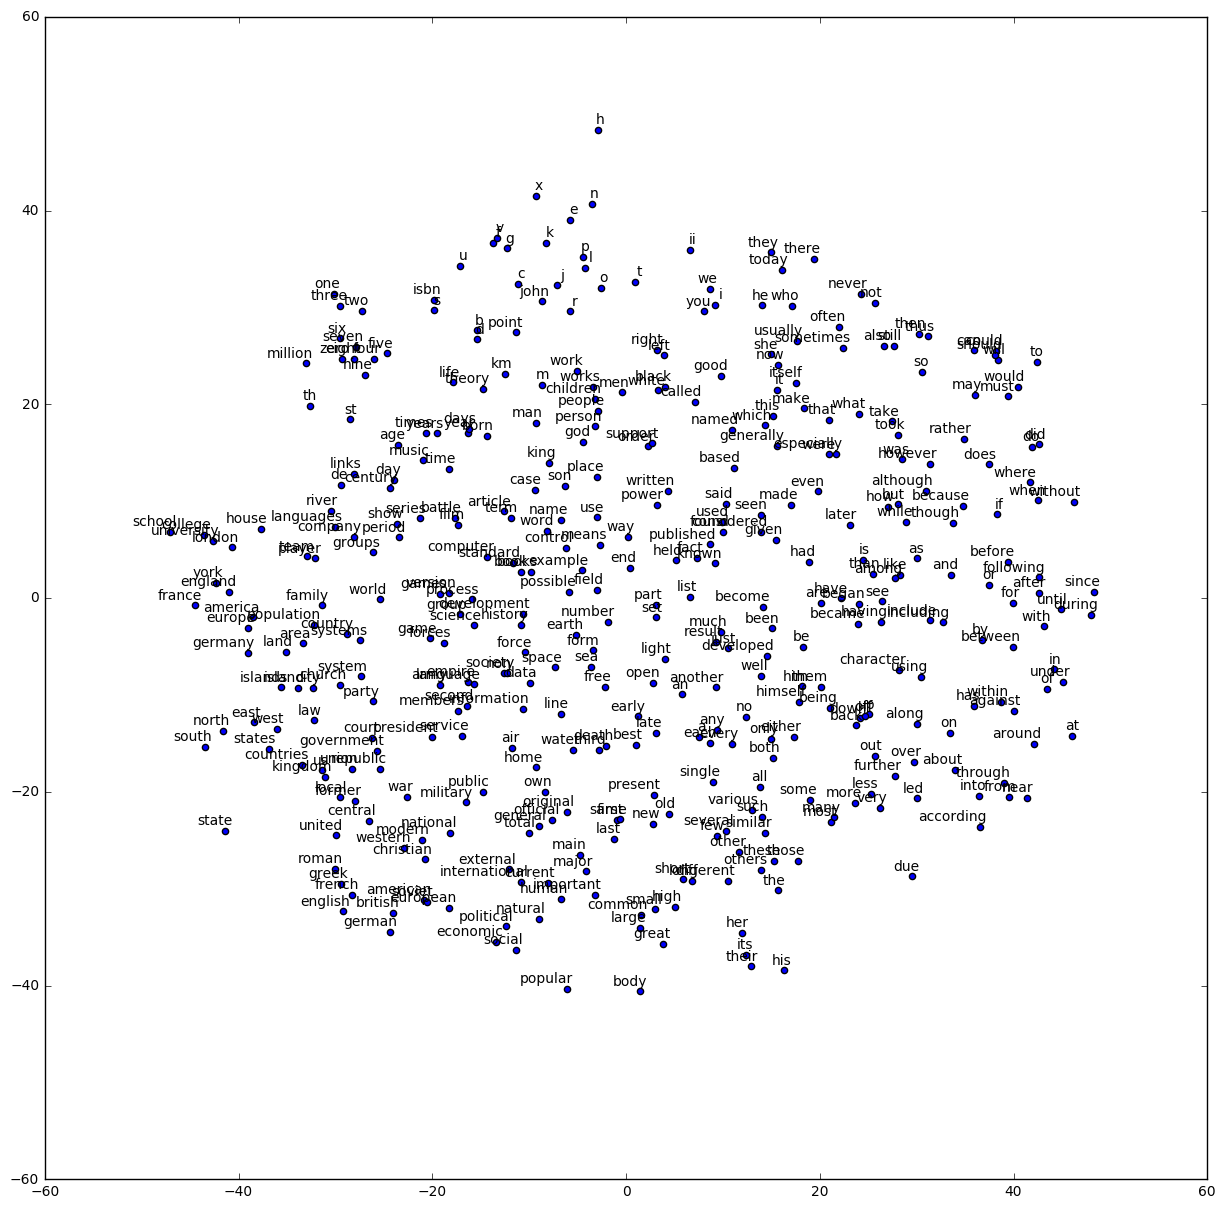

In [14]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)